## Setup and Import Libraries

In [2]:
import torch
import os
from datasets import load_dataset
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from utils import Utils

import warnings
warnings.filterwarnings('ignore')

In [3]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

utils = Utils()
INDEX_NAME = utils.create_index_name('t-ind')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)

pinecone.create_index(
    INDEX_NAME,
    dimension=512,
    metric="dotproduct",
    spec=ServerlessSpec(cloud='aws', region='us-east-1')
)

index = pinecone.Index(INDEX_NAME)

cpu


In [5]:
INDEX_NAME

't-ind-thpugi5b8qynkab8tfzq0ae9gcrijw7ctqaa'

## Load the Dataset

In [6]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)

fashion


Generating train split: 100%|██████████| 44072/44072 [00:00<00:00, 57359.18 examples/s]


Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

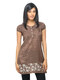

In [7]:
images = fashion['image']
metadata = fashion.remove_columns('image')
images[900]

In [8]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## Create the Sparse Vector Using BM25

In [10]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

100%|██████████| 44072/44072 [00:04<00:00, 10710.64it/s]


'Turtle Check Men Navy Blue Shirt'

In [11]:
bm25.encode_queries(metadata['productDisplayName'][0])
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Create the Dense Vector Using CLIP

In [12]:
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32', 
    device=device
)

model

SentenceTransformer(
  (0): CLIPModel()
)

In [13]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

In [14]:
len(fashion)

44072

## Create Embeddings Using Sparse and Dense

In [15]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    
    # extract image batch
    img_batch = images[i:i_end]
    
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

100%|██████████| 10/10 [01:26<00:00,  8.69s/it]


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

## Run Your Query

In [16]:
query = "dark blue french connection jeans for men"

In [17]:
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

In [18]:
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

In [19]:
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]


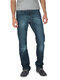
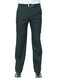
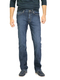
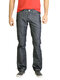
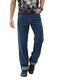
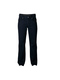
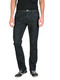
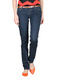
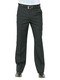
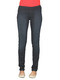
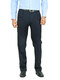
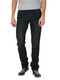
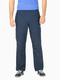
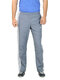

In [21]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

display_result(imgs)

## Scaling the Hybrid Search

In [22]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

###  More Dense

In [23]:
question = "dark blue french connection jeans for men"


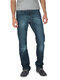
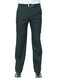
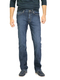
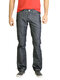
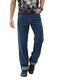
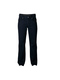

In [24]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)

result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [25]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Gini and Jony Boys Solid Black Jeans


### More Sparse

In [26]:
question = "dark blue french connection jeans for men"


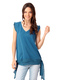
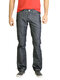
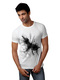
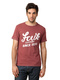
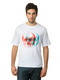
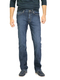

In [30]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)

result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [31]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
French Connection Men White T-shirt
Lee Men Blue Chicago Fit Jeans


### More Dense or More Sparse?

In [29]:
question = "dark blue french connection jeans for men"


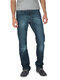
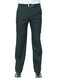
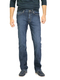
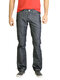
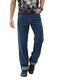
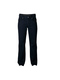

In [34]:
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)

result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [35]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Gini and Jony Boys Solid Black Jeans
